# Object Detection with Tensorflow API

## Google Drive에 데이터 추가

- 준비된 데이터 셋을 자신의 구글 드라이브에 추가합니다.
- 압축을 먼저 해제하고 추가하는 것을 권장합니다.

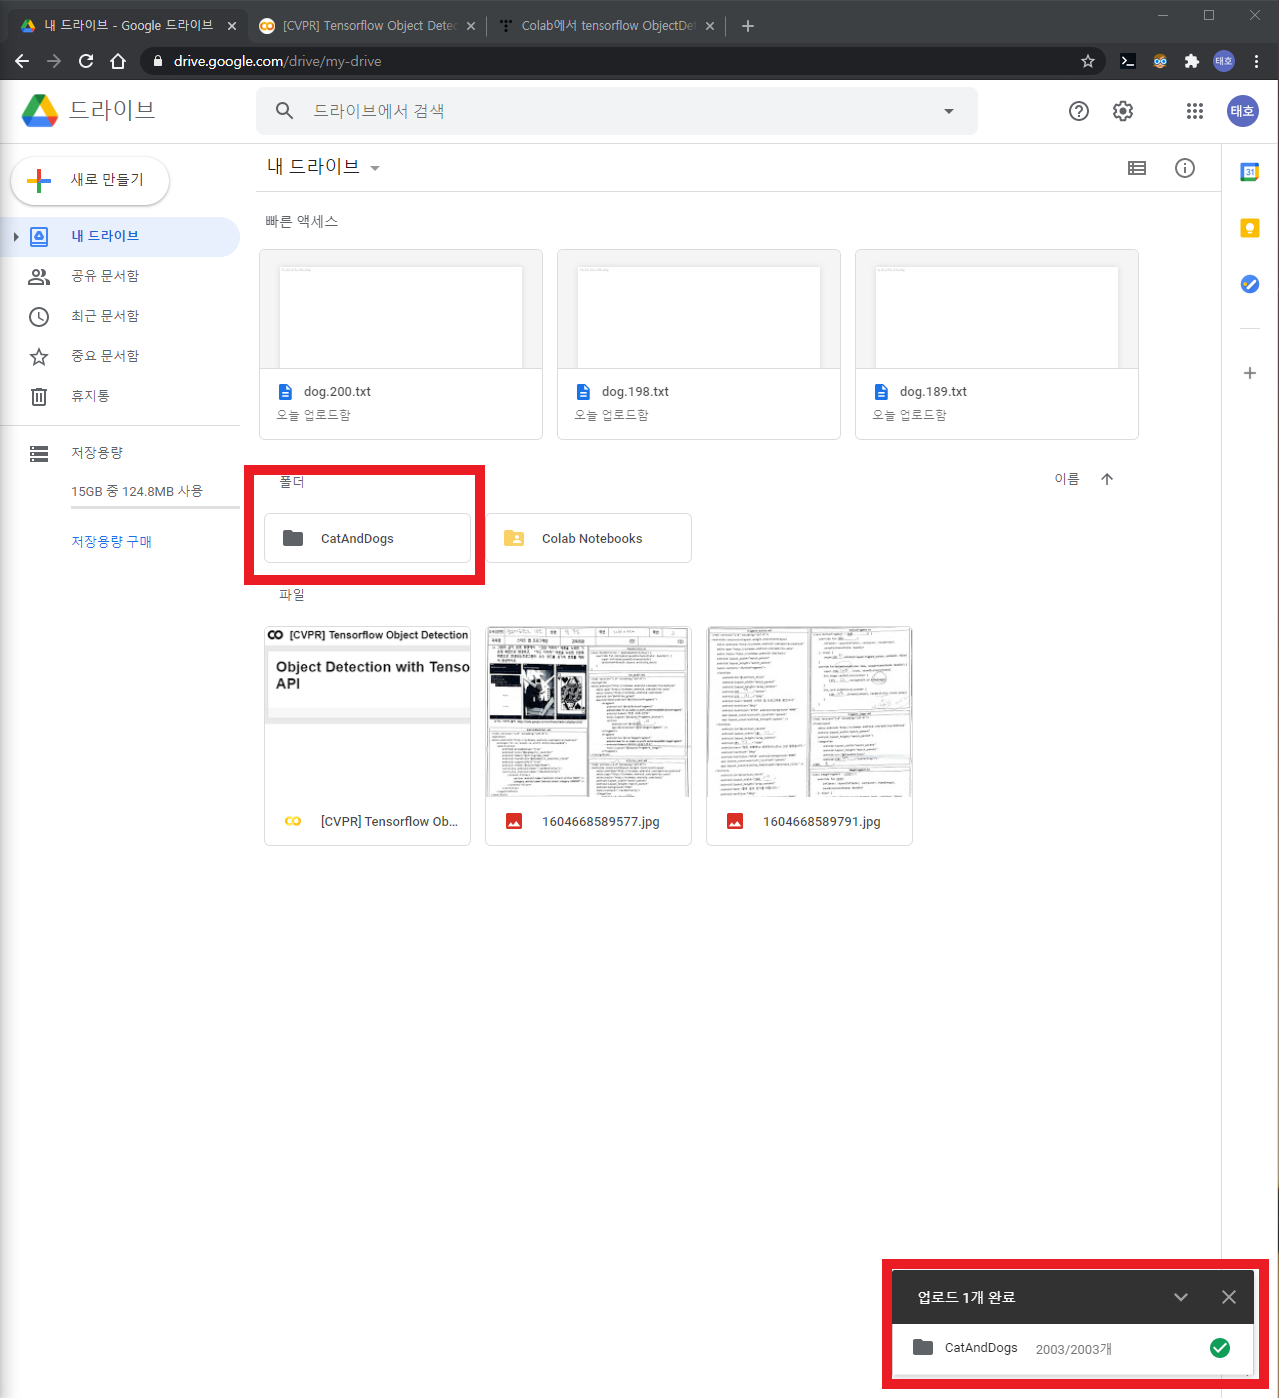

## Google Drive 연동

- Colab은 서버와 연결이 해제되면 기존의 데이터/환경이 사라집니다.
- 따라서 자신의 Drive를 연동하여 사용합니다.

- 연결 시, URL을 클릭하여 아래 과정을 수행합니다.
    - 계정 선택
    - 엑세스 허용
    - 승인 코드 복사 및 입력

> 위 과정은 환경을 초기화하면 다시 해야합니다.
환경이 초기화 되지 않았다면 다시 수행할 때 오류가 발생할 수 있습니다.

In [ ]:
import os, sys
from google.colab import drive

drive.mount('/content/mnt')

- 정상적으로 수행됬다면, 아래 셀을 실행하여 자신의 구글 드라이브 정보를 출력할 수 있습니다.

In [ ]:
! ls /content/mnt/MyDrive

## 환경 설정

아래 항목을 설치합니다.
- Cython
- ProtoBuf
- etc

In [ ]:
!apt-get update

In [ ]:
!apt-get install protobuf-compiler python-lxml python-pil
!pip install Cython pandas tf-slim lvis

Tensorflow에서 제공하는 Object Detection Model Repository를 다운로드 받습니다.

In [ ]:
!git clone https://github.com/tensorflow/models.git

- Protobuf를 컴파일하고 필요한 패키지를 설치합니다.
- PYTHON 환경변수에 이 경로를 등록합니다.

In [ ]:
%cd ./models/research
!protoc object_detection/protos/*.proto --python_out=.

In [ ]:
import os
os.environ['PYTHONPATH'] += ":/content/models"

import sys
sys.path.append("/content/models")

In [ ]:
!cp object_detection/packages/tf2/setup.py .
!python setup.py build
!python setup.py install

### 환경 설정 테스트

- 아래 명령을 통해서 환경이 정상적으로 설정되었는지 확인할 수 있다.

In [ ]:
%cd /content/models/research
!python3 object_detection/builders/model_builder_tf2_test.py

## tf Record 파일 생성

- 딥러닝은 많은 데이터를 활용하여 학습을 수행합니다.
- 모든 데이터를 메모리에 올려서 학습을 수행할 수 있다면 이상적이지만 대부분의 경우 물리적인 한계로 불가능합니다.
- 따라서 당장 학습에 필요한 데이터만 메모리에 올리는 것이 일반적입니다.

</br>

- 이 경우 동일한 데이터에 대해서 parsing, load, store 등의 작업을 반복적으로 수행하게됩니다.
- tf.record는 tensorflow에서 데이터를 프로토콜 버퍼의 형태로 변환하도록 제공합니다.

> 프로토콜 버퍼? </br>
구글에서 개발하고 오픈소스로 공개한, 직렬화 데이타 구조 (Serialized Data Structure)이다. C++,C#, Go, Java, Python, Object C, Javascript, Ruby 등 다양한 언어를 지원하며 특히 직렬화 속도가 빠르고 직렬화된 파일의 크기도 작아서 Apache Avro 파일 포맷과 함께 많이 사용된다. </br></br>
출처: https://bcho.tistory.com/1182

### 데이터 파싱 및 CSV 파일 생성

- 일반적으로 Labeling 데이터는 유명한 데이터셋의 저장 형식을 모방합니다.

    - voc (xml)
      ```xml  
    <annotation>
      <folder>Definitiva</folder>
      <filename>armas (1)</filename>
      <path>armas (1).jpg</path>
      <source>
        <database>Unknown</database>
      </source>
      <size>
        <width>240</width>
        <height>145</height>
        <depth>3</depth>
      </size>
      <segmented>0</segmented>
      <object>
        <name>pistol</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
          <xmin>3</xmin>
          <ymin>1</ymin>
          <xmax>128</xmax>
          <ymax>100</ymax>
        </bndbox>
      </object>
      <object>
        <name>pistol</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <difficult>0</difficult>
        <bndbox>
          <xmin>123</xmin>
          <ymin>47</ymin>
          <xmax>238</xmax>
          <ymax>145</ymax>
        </bndbox>
      </object>
    </annotation>
      ```
    - coco (json)
    ```json
    "info": {
        "description": "COCO 2017 Dataset",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2017,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
    }
    ...
    "area": 1037.7818999999995,
        "iscrowd": 0,
        "image_id": 397133,
        "bbox": [
            0,
            262.81,
            62.16,
            36.77
        ],
        "category_id": 1,
        "id": 1218137
        }

    "segmentation": [
            [
            292.37,
            425.1,
            340.6,
            373.86,
            347.63,
            256.31,
            198.93,
            240.24,
            4.02,
            311.57,
            1,
            427,
            291.36,
            427
            ]
        ]
    ```

- 우리는 직접 정의한 text 파일 형식으로 데이터를 작성하였으므로 parsing 코드를 직접 작성해야 합니다.

- 아래 코드의 빈 부분은 직접 작성해보시길 바랍니다.

In [ ]:
from __future__ import division, print_function, absolute_import

import pandas as pd
import numpy as np
import csv

import re
import os
import io
import glob
import shutil
import urllib.request
import tarfile
import xml.etree.ElementTree as ET

import tensorflow as tf
import cv2 

from PIL import Image
from collections import namedtuple, OrderedDict

# 더 사용할 라이브러리를 아래에 추가하세요.
# import ...

- 여러분의 Drive 경로에 맞도록 아래 PATH 디렉터리를 수정해주세요.
- 제공된 디렉터리 구조를 변경하지 않았다면, BASE만 수정해도 충분합니다.

In [ ]:
BASE  = 'BASE'
IMAGE = 'image'
TRAIN = 'train'
TEST  = 'test'

PATH = {
    BASE: '/content/mnt/MyDrive/CatAndDogs'
}

PATH[IMAGE] = os.path.join(PATH[BASE], 'images')
PATH[TRAIN] = os.path.join(PATH[BASE], 'train_labels')
PATH[TEST]  = os.path.join(PATH[BASE], 'test_labels')

for key, value in PATH.items():
    print('{:10} {}'.format(key, value))

In [ ]:
def parse_text(text_file: str) -> tuple:
    '''
    텍스트파일의 데이터를 파싱하고 필요한 정보를 반환합니다.

    Args:
        text_file: 텍스트파일의 경로가 문자열로 주어집니다.
    Returns:
        tuple: 2가지 원소를 포함한 튜플을 반환합니다.
        1: 텍스트 파일에 포함된 클래스의 종류로 이루어진 리스트입니다. (중복된 원소는 제거되어있습니다.)
        2: 필요한 정보로 구성된 리스트입니다. 각 정보는 아래의 순서로 이루어진 튜플입니다.
            (해당하는 이미지 파일명, 이미지 가로 크기, 이미지 세로 크기, 클래스, xmin, ymin, xmax, ymax)
            또한 해당 타입은
            (str, int, int, str, int, int, int, int) 입니다.
    '''
    classes_names = []
    object_infos = []

    # 직접 작성해보세요.

    text = []
    new_list = []

    filename = os.path.basename(text_file)
    imgname = os.path.join(PATH[IMAGE], filename.rstrip('.txt') + '.jpg')
    img = Image.open(imgname)

    w, h = img.size

    f = open(text_file, 'r')

    lines = f.readlines()
    for line in lines:
      text = line.split(',')

      classes = text[4].rstrip('\n').lower()

      new_list.append(classes)

      object_infos.append((imgname, w, h, classes, int(text[0]), int(text[1]), int(text[2]), int(text[3])))

    f.close()

    for v in new_list:
      if v not in classes_names:
        classes_names.append(v)

    tuple(classes_names)
    tuple(object_infos)

    return classes_names, object_infos

In [ ]:
def text_to_csv(directory: str) -> tuple:
    '''
    디렉터리를 입력받고, 디렉터리 내부의 텍스트파일들을 파싱합니다.
    파싱한 데이터를 하나로 추합하여 반환합니다.

    Args:
        directory: 디렉터리 경로가 포함된 문자열로 주어집니다.
    Returns:
        tuple: 2가지 원소를 포함한 튜플을 반환합니다.
        1: 모든 텍스트 파일에 포함된 크래스의 종류로 이루어진 리스트입니다. (중복된 원소는 제거되어있습니다.)
        2: 필요한 정보로 구성된 pandas DataFrame 클래스 입니다.
    '''
    classes_names = []
    object_infos = []

    for text_file in glob.glob(os.path.join(directory, '*.txt')):
        sub_classes, sub_object_infos = parse_text(text_file)

        classes_names += sub_classes
        object_infos += sub_object_infos
    
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    txt_df = pd.DataFrame(object_infos, columns=column_name)
    classes_names = list(set(classes_names))
    classes_names.sort()

    return txt_df, classes_names

In [ ]:
CSV = 'CSV'

for TYPE in (TRAIN, TEST):
    print('{:10} {}'.format('From', PATH[TYPE]))
    txt_df, classes = text_to_csv(PATH[TYPE])
    PATH[CSV] = os.path.join(PATH[BASE], f'{TYPE}.csv')
    txt_df.to_csv(PATH[CSV])
    print('{:10} {}'.format('To', PATH[CSV]))

- 위 과정을 모두 정상적으로 수행했다면, 구글 드라이브열고 .csv 파일이 생성되었는지 확인하고 그 형태가 정상적인지 확인해보세요.

- 또한 아래 셀에서 classes를 출력해보세요.
- 코드 혹은 데이터에 이상이 없다면 classes는 dog, cat 두 가지여야 합니다.

In [ ]:
print(len(classes))
print(classes)

### pbtxt 파일 생성

- `classes`의 클래스 목록을 통해서 pbtxt 파일을 생성합니다.
- pbtxt 파일은 프로토콜 버퍼에서 사용하는 데이터로 각 클래스의 이름과 id를 묶는 용도로 사용됩니다.


In [ ]:
pbtxt_path = os.path.join(PATH[BASE], 'label_map.pbtxt')
pbtxt_content = ''

for index, name in enumerate(classes):
    pbtxt_content = (
        pbtxt_content +
        "item {{\n    id: {0}\n    name: '{1}'\n}}\n\n".format(index + 1, name)
    )
pbtxt_content = pbtxt_content.strip()

with open(pbtxt_path, 'wt') as ostream:
    ostream.write(pbtxt_content)

- 구글 드라이브로 돌아가서 label_map.pbtxt 파일이 정상적으로 생성되었는지 확인해보세요.
- 아래의 형태로 저장되어 있어야 합니다.

```pbtxt
item {
    id: 1
    name: 'cat'
}

item {
    id: 2
    name: 'dog'
}

```

- 또한 tf.Record 생성 시 필요한 mapping 함수를 작성해야합니다.
- class가 입력으로 들어오면 정수(id)로 변환하고, 이는 pbtxt와 일치해야합니다.

In [ ]:
def class_text_to_int(row_label: str) -> int:
    if row_label == 'cat':
        return 1
    elif row_label == 'dog':
        return 2

### tf.Record 생성

In [ ]:
import tensorflow as tf
from collections import namedtuple
from object_detection.utils import dataset_util

In [ ]:
def split(df, group):
    data = namedtuple('data', 'filename object')
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]

In [ ]:
def create_tf_example(group, path):
    with tf.io.gfile.GFile(os.path.join(path, '{}'.format(group.filename)), 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'jpg'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        
        ########### ADDITIONAL CHECKS START HERE ###################

        xmn = row['xmin'] / width
        if xmn < 0.0:
            xmn = 0.0
        elif xmn > 1.0:
            xmn = 1.0
        xmins.append(xmn)

        xmx = row['xmax'] / width
        if xmx < 0.0:
            xmx = 0.0
        elif xmx > 1.0:
            xmx = 1.0
        xmaxs.append(xmx)

        ymn = row['ymin'] / height
        if ymn < 0.0:
            ymn = 0.0
        elif ymn > 1.0:
            ymn = 1.0
        ymins.append(ymn)

        ymx = row['ymax'] / height
        if ymx < 0.0:
            ymx = 0.0
        elif ymx > 1.0:
            ymx = 1.0
        ymaxs.append(ymx)

        ############ ADDITIONAL CHECKS END HERE ####################

        classes_text.append(row['class'].encode('utf8'))
        classes.append(class_text_to_int(row['class']))

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_jpg),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

In [ ]:
RECORD = 'tf.Record'

for TYPE in (TRAIN, TEST):
    PATH[CSV] = os.path.join(PATH[BASE], f'{TYPE}.csv')
    PATH[RECORD] = PATH[CSV].replace('csv', 'record')
    writer = tf.io.TFRecordWriter(PATH[RECORD])
    examples = pd.read_csv(PATH[CSV])
    grouped = split(examples, 'filename')
    for group in grouped:
        tf_example = create_tf_example(group, PATH[IMAGE])
        writer.write(tf_example.SerializeToString())
    writer.close()
    print('{:10} {}'.format('From', PATH[CSV]))
    print('{:10} {}'.format('To', PATH[RECORD]))

## 미리 학습된 모델 다운로드

- Tensorflow API에서는 COCO Dataset으로 pre-trained 된 모델을 제공하고 있습니다.

- https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

- 이 중, EfficientDet D0 을 사용해서 학습을 진행합니다.

- 먼저, 디렉터리 경로를 생성합니다.

In [ ]:
%cd /content/
%mkdir Custom
%mkdir Custom/models
%mkdir Custom/pre-trained-models
%mkdir Custom/export-models
!ls -r Custom

- 이 후, 미리 학습된 모델을 다운로드 받고 압축을 해제합니다.

In [ ]:
%cd /content/Custom/pre-trained-models/
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
!tar -zxvf efficientdet_d0_coco17_tpu-32.tar.gz
!rm efficientdet_d0_coco17_tpu-32.tar.gz

- 미리 학습된 모델의 config 파일을 복사하여 옵션을 수정합니다.

In [ ]:
with open('/content/mnt/MyDrive/CatAndDogs/train.csv', 'rt') as file:
  for index, line in enumerate(file.readlines()[1:]):
    values = list(map(int, line.split(',')[5:]))
    if (values[0] > values[2]) or (values[1] > values[3]):
      print(line)
    if list(filter(lambda x: x<0, values)):
      print(line)

In [ ]:
%cd /content/Custom/
!mkdir models/EfficentD0
%cp pre-trained-models/efficientdet_d0_coco17_tpu-32/pipeline.config models/EfficentD0
%ls models/EfficentD0

- 좌측 파일 탐색기에서 `pipeline.config`를 수정합니다.

```
line 3:
num_classes: 2
```

```
line 134:
batch_size: ???
# OOM 에러발생 시, 더 낮추시오
```

```
line 162:
num_steps: ???
# 학습 시간
```

```
line 152:
line 162와 동일하게

line 154:
line 152보다 절반 이하로 작게
```

```
line 161:
fine_tune_checkpoint: "pre-trained-model 경로/checkpoint/ckpt-0"
```

```
line 167:
fine_tune_checkpoint_type: "detection"
```

```
line 172, 185
label_map.pbtxt 경로
```

```
line 174, 189
record 파일 경로
```

### 데이터 오그멘테이션 추가

- 첨부 자료 및 말로 설명

## 학습

- models/research 경로에서 수행 (파이썬 환경변수 때문)
- object_detection/model_main_tf2.py 파일 실행
    - --pipeline_config_path=
    - --model_dir=


In [ ]:
%cd /content/models/research/
!python object_detection/model_main_tf2.py --pipeline_config_path /content/Custom/models/EfficentD0/pipeline.config --model_dir /content/Custom/models/EfficentD0

## 학습된 모델 내보내기

- 학습 완료 후, 학습된 모델을 다른 디렉터리로 내보내는 과정
- models/research 경로에서 수행
- object_detection/exporter_main_v2.py
    - --input_type image_tensor
    - --pipeline_config_path ???
    - --trained_checkpoint_dir ???
    - --output_directory ???

- 이 때, output_directory는 Custom/exported-models 아래로 지정

In [ ]:
%cd /content/models/research/
!python object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path /content/Custom/models/EfficentD0/pipeline.config --trained_checkpoint_dir /content/Custom/pre-trained-models/efficientdet_d0_coco17_tpu-32/checkpoint --output_directory /content/Custom/export-models

## 평가

- 학습이 완료된 모델을 평가하여 mAP를 계산

* mAP @ IoU=.50:.05:.95 : 10 개의 IoU 임계 값 (즉, 0.50, 0.55, 0.60,…, 0.95)에 대한 평균
  - 주요 대회 평가 지표
* mAP @ IoU=.50 : IoU 임계값 0.50 일때의 mAP
  - PASCAL VOC 평가 지표

* mAP @ small : 32x32 픽셀보다 작은 크기의 객체에 대한 mAP
* mAP @ medium : 32x32 이상 96x96 이하 픽셀 객체에 대한 mAP
* mAP @ large : 96x96 픽셀보다 큰 크기의 객체에 대한 mAP


In [ ]:
# COCO API를 설치
%cd /content/
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cp -r pycocotools /content/models/research/

- models/research 에서 수행
- object_detection/model_main_tf2.py
    - --pipeline_config_path
    - --model_dir ??? (export 모델 경로)
    - --checkpoint_dir ??? (export 모델 경로 아래의 checkpoint)


In [ ]:
%cd /content/models/research/
!python object_detection/model_main_tf2.py --pipeline_config_path /content/Custom/export-models/pipeline.config --model_dir /content/Custom/export-models --checkpoint_dir /content/Custom/export-models/checkpoint

## 물체 탐지

- 학습된 모델로 실제 객체를 탐지

In [ ]:
PATH_TO_CFG = "/content/Custom/export-models/pipeline.config"
PATH_TO_CKPT = "/content/Custom/export-models/checkpoint"

In [ ]:
!pip install official

In [ ]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
import os

In [ ]:
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

In [ ]:
import tensorflow as tf
# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

In [ ]:
@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

In [ ]:
PATH_TO_LABELS = "/content/mnt/MyDrive/CatAndDogs/label_map.pbtxt"

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

In [ ]:
import numpy as np
from PIL import Image
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore') 

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

In [ ]:
def inference(image_np):
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=200,
            min_score_thresh=.30,
            agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)

In [ ]:
image_np = load_image_into_numpy_array("/content/mnt/MyDrive/CatAndDogs/cat2.jfif")
inference(image_np)